In [201]:
import os
import time

import pyreadr as py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, RMSprop
from torch.optim.lr_scheduler import StepLR

from sklearn.model_selection import train_test_split

torch.manual_seed(42)
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

cuda:3


> ### Data downloading
Data link  
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/6C3JR1

##### Data description
Here we consoder dataset of "Additional Tennessee Eastman Process Simulation Data for Anomaly Detection Evaluation"
This dataverse contains the data referenced in Rieth et al. (2017). Issues and Advances in Anomaly Detection Evaluation for Joint Human-Automated Systems. To be presented at Applied Human Factors and Ergonomics 2017.
##### Columns description
* **faultNumber** ranges from 1 to 20 in the “Faulty” datasets and represents the fault type in the TEP. The “FaultFree” datasets only contain fault 0 (i.e. normal operating conditions).
* **simulationRun** ranges from 1 to 500 and represents a different random number generator state from which a full TEP dataset was generated (Note: the actual seeds used to generate training and testing datasets were non-overlapping).
* **sample** ranges either from 1 to 500 (“Training” datasets) or 1 to 960 (“Testing” datasets). The TEP variables (columns 4 to 55) were sampled every 3 minutes for a total duration of 25 hours and 48 hours respectively. Note that the faults were introduced 1 and 8 hours into the Faulty Training and Faulty Testing datasets, respectively.
* **columns 4-55** contain the process variables; the column names retain the original variable names.

In [2]:
# ! unzip dataverse_files.zip -d dataverse_files

In [3]:
#reading train data in .R format
a1 = py.read_r("dataverse_files/TEP_FaultFree_Training.RData")
a2 = py.read_r("dataverse_files/TEP_Faulty_Training.RData")

In [4]:
#reading test data in .R format
a3 = py.read_r("dataverse_files/TEP_FaultFree_Testing.RData")
a4 = py.read_r("dataverse_files/TEP_Faulty_Testing.RData")

In [5]:
print("Objects that are present in a1 :", a1.keys())
print("Objects that are present in a2 :", a2.keys())
print("Objects that are present in a3 :", a3.keys())
print("Objects that are present in a4 :", a4.keys())

Objects that are present in a1 : odict_keys(['fault_free_training'])
Objects that are present in a2 : odict_keys(['faulty_training'])
Objects that are present in a3 : odict_keys(['fault_free_testing'])
Objects that are present in a4 : odict_keys(['faulty_testing'])


In [6]:
# concatinating the train and the test dataset

# train dataframe
raw_train = pd.concat([a1['fault_free_training'], a2['faulty_training']])
# test dataframe
raw_test = pd.concat([a3['fault_free_testing'], a4['faulty_testing']])

In [7]:
raw_train.groupby(['faultNumber','simulationRun']).size()

faultNumber  simulationRun
0.0          1.0              500
             2.0              500
             3.0              500
             4.0              500
             5.0              500
                             ... 
20.0         496.0            500
             497.0            500
             498.0            500
             499.0            500
             500.0            500
Length: 10500, dtype: int64

In [8]:
raw_test.groupby(['faultNumber','simulationRun']).size()

faultNumber  simulationRun
0            1.0              960
             2.0              960
             3.0              960
             4.0              960
             5.0              960
                             ... 
20           496.0            960
             497.0            960
             498.0            960
             499.0            960
             500.0            960
Length: 10500, dtype: int64

> ### EDA

In [9]:
# for col in raw_train.columns[3:]:
#     plt.figure(figsize=(10,5))
#     plt.hist(raw_train[col])
#     plt.xlabel(col)
#     plt.ylabel('counts')
#     plt.show()

In [208]:
raw_train['simulationRun'].value_counts()

1.0      10500
172.0    10500
159.0    10500
160.0    10500
161.0    10500
         ...  
340.0    10500
341.0    10500
342.0    10500
343.0    10500
2.0      10500
Name: simulationRun, Length: 500, dtype: int64

In [210]:
raw_train.groupby(['faultNumber', 'simulationRun'])['sample'].count()

faultNumber  simulationRun
0.0          1.0              500
             2.0              500
             3.0              500
             4.0              500
             5.0              500
                             ... 
20.0         496.0            500
             497.0            500
             498.0            500
             499.0            500
             500.0            500
Name: sample, Length: 10500, dtype: int64

In [213]:
25*60 / 3

500.0

In [227]:
len(raw_train) / 500, len(raw_test) / 960

(10500.0, 10500.0)

In [224]:
raw_train.groupby(['faultNumber', 'simulationRun'])['xmeas_1'].apply(lambda x: list(x)).reset_index()

,faultNumber,simulationRun,xmeas_1
0,0.0,1.0,"[0.25038, 0.25109, 0.25038, 0.24977, 0.29405, ..."
1,0.0,2.0,"[0.25225, 0.25152, 0.24869, 0.2521, 0.24039, 0..."
2,0.0,3.0,"[0.2488, 0.25269, 0.25271, 0.25098, 0.28097, 0..."
3,0.0,4.0,"[0.25117, 0.24957, 0.24942, 0.25156, 0.30868, ..."
4,0.0,5.0,"[0.25071, 0.25063, 0.24981, 0.25111, 0.24711, ..."
...,...,...,...
10495,20.0,496.0,"[0.25131, 0.24839, 0.25201, 0.25067, 0.21982, ..."
10496,20.0,497.0,"[0.24826, 0.25072, 0.2513, 0.25189, 0.2094, 0...."
10497,20.0,498.0,"[0.24978, 0.25126, 0.25202, 0.25201, 0.24591, ..."
10498,20.0,499.0,"[0.25056, 0.25128, 0.25055, 0.25023, 0.28635, ..."


In [239]:
raw_train

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,20.0,500.0,496,0.23419,3655.3,4461.7,9.3448,27.008,42.481,2703.0,...,53.670,23.350,61.061,20.719,40.999,38.653,47.386,47.528,40.212,17.659
4999996,20.0,500.0,497,0.26704,3647.4,4540.2,9.3546,27.034,42.671,2704.7,...,54.650,26.362,60.020,20.263,41.579,33.624,47.536,47.647,41.199,18.741
4999997,20.0,500.0,498,0.26543,3630.3,4571.6,9.4089,27.129,42.470,2705.1,...,54.274,26.521,59.824,20.189,41.505,40.967,52.437,47.802,41.302,23.199
4999998,20.0,500.0,499,0.27671,3655.7,4498.9,9.3781,27.353,42.281,2705.8,...,53.506,26.781,62.818,20.453,40.208,40.957,47.628,48.086,40.510,15.932


In [235]:
raw_train.groupby(['faultNumber', 'simulationRun']).agg({'xmeas_1': list, 'xmeas_2': list}).reset_index()

,faultNumber,simulationRun,xmeas_1,xmeas_2
0,0.0,1.0,"[0.25038, 0.25109, 0.25038, 0.24977, 0.29405, ...","[3674.0, 3659.4, 3660.3, 3661.3, 3679.0, 3691...."
1,0.0,2.0,"[0.25225, 0.25152, 0.24869, 0.2521, 0.24039, 0...","[3683.6, 3652.7, 3650.6, 3669.4, 3660.0, 3650...."
2,0.0,3.0,"[0.2488, 0.25269, 0.25271, 0.25098, 0.28097, 0...","[3691.0, 3638.4, 3694.2, 3634.5, 3660.7, 3649...."
3,0.0,4.0,"[0.25117, 0.24957, 0.24942, 0.25156, 0.30868, ...","[3641.2, 3652.0, 3665.6, 3659.6, 3679.7, 3697...."
4,0.0,5.0,"[0.25071, 0.25063, 0.24981, 0.25111, 0.24711, ...","[3658.3, 3638.9, 3624.0, 3641.8, 3657.6, 3655...."
...,...,...,...,...
10495,20.0,496.0,"[0.25131, 0.24839, 0.25201, 0.25067, 0.21982, ...","[3671.1, 3656.8, 3656.9, 3643.7, 3655.8, 3661...."
10496,20.0,497.0,"[0.24826, 0.25072, 0.2513, 0.25189, 0.2094, 0....","[3666.5, 3674.8, 3643.6, 3654.4, 3590.4, 3594...."
10497,20.0,498.0,"[0.24978, 0.25126, 0.25202, 0.25201, 0.24591, ...","[3679.1, 3659.2, 3682.6, 3662.6, 3667.5, 3621...."
10498,20.0,499.0,"[0.25056, 0.25128, 0.25055, 0.25023, 0.28635, ...","[3662.4, 3642.7, 3633.1, 3646.8, 3679.1, 3661...."


In [236]:
tmp = raw_train[(raw_train['faultNumber'] == 0) & (raw_train['simulationRun'] == 1)]

In [242]:
tmp.drop(['faultNumber', 'simulationRun', 'sample'], axis=1)

,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,74.863,120.41,0.33818,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,75.000,120.41,0.33620,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,74.771,120.42,0.33563,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,75.224,120.39,0.33553,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,75.388,120.39,0.32632,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.24602,3651.9,4504.4,9.4721,26.600,42.312,2707.2,74.623,120.40,0.32381,...,54.132,23.663,59.588,22.481,38.952,33.489,45.203,49.900,41.057,16.448
496,0.23457,3663.0,4529.5,9.3440,26.872,42.434,2704.1,75.123,120.40,0.35454,...,54.028,22.776,60.566,22.237,42.978,38.017,42.637,50.075,41.339,17.435
497,0.23068,3656.4,4493.0,9.2978,26.920,42.536,2700.3,74.942,120.39,0.35859,...,54.465,23.158,62.102,21.639,42.483,41.016,46.782,50.098,41.277,18.315
498,0.24263,3632.5,4521.5,9.3915,26.956,42.317,2701.9,74.900,120.37,0.34057,...,54.532,23.386,63.164,22.661,39.558,37.892,47.468,50.312,40.557,19.198


In [248]:
tmp.drop(['faultNumber', 'simulationRun', 'sample'], axis=1).values.shape

(500, 52)

In [254]:
raw_train['index'] = raw_train['faultNumber'] * 500 + raw_train['simulationRun']

In [255]:
raw_train

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11,index
0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447,1.0
1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194,1.0
2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530,1.0
3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089,1.0
4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,20.0,500.0,496,0.23419,3655.3,4461.7,9.3448,27.008,42.481,2703.0,...,23.350,61.061,20.719,40.999,38.653,47.386,47.528,40.212,17.659,10500.0
4999996,20.0,500.0,497,0.26704,3647.4,4540.2,9.3546,27.034,42.671,2704.7,...,26.362,60.020,20.263,41.579,33.624,47.536,47.647,41.199,18.741,10500.0
4999997,20.0,500.0,498,0.26543,3630.3,4571.6,9.4089,27.129,42.470,2705.1,...,26.521,59.824,20.189,41.505,40.967,52.437,47.802,41.302,23.199,10500.0
4999998,20.0,500.0,499,0.27671,3655.7,4498.9,9.3781,27.353,42.281,2705.8,...,26.781,62.818,20.453,40.208,40.957,47.628,48.086,40.510,15.932,10500.0


In [214]:
raw_train.columns

Index(['faultNumber', 'simulationRun', 'sample', 'xmeas_1', 'xmeas_2',
       'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8',
       'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14',
       'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18', 'xmeas_19', 'xmeas_20',
       'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25', 'xmeas_26',
       'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32',
       'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38',
       'xmeas_39', 'xmeas_40', 'xmeas_41', 'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4',
       'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11'],
      dtype='object')

In [11]:
raw_train['faultNumber'].value_counts()

1.0     250000
10.0    250000
2.0     250000
3.0     250000
4.0     250000
5.0     250000
6.0     250000
7.0     250000
8.0     250000
9.0     250000
11.0    250000
20.0    250000
12.0    250000
13.0    250000
14.0    250000
15.0    250000
16.0    250000
17.0    250000
18.0    250000
19.0    250000
0.0     250000
Name: faultNumber, dtype: int64

> ### Sampling

Described in "Data Preparation for Deep Learning Models" in [that article](https://medium.com/@mrunal68/tennessee-eastman-process-simulation-data-for-anomaly-detection-evaluation-d719dc133a7f)

In [259]:
# 5.250.000, 10.080.000
len(raw_train), len(raw_test)

(5250000, 10080000)

In [260]:
X_train_val = raw_train.drop(['faultNumber', 'simulationRun', 'sample'], axis=1)
y_train_val = raw_train['faultNumber']

X_test = raw_test.drop(['faultNumber', 'simulationRun', 'sample'], axis=1)
y_test = raw_test['faultNumber']

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, 
                                                  y_train_val, 
                                                  test_size=0.2, 
                                                  stratify=y_train_val, 
                                                  random_state=True)

In [15]:
list(map(len, [X_train, X_val, X_test]))

[4200000, 1050000, 10080000]

In [256]:
# class DataTEP(Dataset):

#     def __init__(self, X, y):
    
#         self.X = X.values
#         self.y = y.values

#     def __len__(self):
#         return len(self.X)

#     def __getitem__(self, idx):
        
#         features = self.X[idx]
#         target = self.y[idx]
        
#         features = torch.tensor(features, dtype=torch.float).unsqueeze(-1)
#         target = torch.tensor(target, dtype=torch.long) 

#         return features, target

class DataTEP(Dataset):

    def __init__(self, X, y):
    
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        features = self.X[self.X['index'] == inx].values
        target = self.y[idx]
        
        features = torch.tensor(features, dtype=torch.float)
        target = torch.tensor(target, dtype=torch.long) 

        return features, target

In [257]:
train_ds = DataTEP(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

val_ds = DataTEP(X_val, y_val)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE*2)

test_ds = DataTEP(X_test, y_test)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE*4)

In [258]:
train_ds[0]

KeyError: 'index'

In [91]:
def accuracy(y_pred, target):
    
    y_pred = torch.softmax(y_pred, dim=1)
    y_pred = torch.max(y_pred, dim=1)[1]  
    
    return torch.eq(y_pred, target).sum().item()

```python
model_1 = Sequential()
model_1.add(LSTM(256, input_shape=(52, 1), return_sequences=True))
model_1.add(LSTM(128, return_sequences=False))
model_1.add(Dense(300))
model_1.add(Dropout(0.5))
model_1.add(Dense(128))
model_1.add(Dense(21, activation='softmax'))
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_1.summary())
```

In [160]:
class Model(torch.nn.Module) :
    def __init__(self, NUM_LAYERS, INPUT_SIZE, HIDDEN_SIZE, LINEAR_SIZE, OUTPUT_SIZE, DEVICE):
        super().__init__()
        
        self.hidden_size = HIDDEN_SIZE
        self.num_layers = NUM_LAYERS
        self.input_size = INPUT_SIZE
        self.linear_size = LINEAR_SIZE
        self.output_size = OUTPUT_SIZE
        
        self.lstm = nn.LSTM(
                            input_size=self.input_size, 
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers, 
                            batch_first=True,
                            dropout=0.4
            )
        
#         self.lstm_2 = nn.LSTM(
#                             input_size=self.hidden_sizes[0],
#                             hidden_size=self.hidden_sizes[1],
#                             num_layers=self.num_layers, 
#                             batch_first=True,
# #                             dropout=0.4
#             )
        
        self.head = nn.Sequential(
                            nn.Linear(in_features=self.hidden_size, out_features=self.linear_size),
                            nn.ReLU(),
                            nn.Dropout(p=0.4),
                            nn.Linear(in_features=self.linear_size, out_features=OUTPUT_SIZE),
            )
        
    def forward(self, x):
    
        x, _ = self.lstm(x)

#         x, __ = self.lstm_2(x)
        
        x = self.head(x[:, -1])
        
        return x

In [193]:
BATCH_SIZE = 64
NUM_CLASSES = 21
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

In [194]:
model = Model(NUM_LAYERS=2, INPUT_SIZE=1, HIDDEN_SIZE=256, LINEAR_SIZE=128, OUTPUT_SIZE=NUM_CLASSES, DEVICE=device)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

In [195]:
for i, (X_batch_train, y_batch_train) in enumerate(train_dl):
    if i < 3:  
        X_batch_train, y_batch_train = X_batch_train.to(device), y_batch_train.to(device)
        y_pred_train = model(X_batch_train)
        print("y_pred_train.size()", y_pred_train.size())
    else:
        break

y_pred_train.size() torch.Size([64, 21])
y_pred_train.size() torch.Size([64, 21])
y_pred_train.size() torch.Size([64, 21])


In [204]:
def train_model(model, optimizer, scheduler, train_dl, val_dl, device):

    loss_train_all, loss_val_all = [], []
    accuracy_train_all, accuracy_val_all = [], []

    for epoch in range(NUM_EPOCHS):

        start = time.time()
        print(f'Epoch: {epoch}, Learning Rate: {scheduler.get_lr()[0]}\n')

        loss_epoch_train, loss_epoch_val = 0, 0
        correct_train, correct_val, total_train, total_val = 0, 0, 0, 0

        model.train()
        for (X_batch_train, y_batch_train) in tqdm(train_dl):

            X_batch_train, y_batch_train = X_batch_train.to(device), y_batch_train.to(device)

            optimizer.zero_grad()

            y_pred_train = model(X_batch_train)
            loss_train = criterion(y_pred_train, y_batch_train)

            loss_train.backward()
            optimizer.step()

            loss_epoch_train += loss_train.item()
            correct_train += accuracy(y_pred_train, y_batch_train)
            total_train += y_batch_train.size()[0]

        scheduler.step()
        model.eval()

        with torch.no_grad():
            for (X_batch_val, y_batch_val) in tqdm(val_dl):

                X_batch_val, y_batch_val = X_batch_val.to(device), y_batch_val.to(device)

                y_pred_val = model(X_batch_val)
                loss_val = criterion(y_pred_val, y_batch_val)

                loss_epoch_val += loss_val.item()

                correct_val += accuracy(y_pred_val, y_batch_val)
                total_val += y_batch_val.size()[0]


        loss_train_tmp = loss_epoch_train / len(train_dl)
        loss_val_tmp = loss_epoch_val / len(val_dl)

        loss_train_all.append(loss_train_tmp)
        loss_val_all.append(loss_val_tmp)

        accuracy_train_tmp = correct_train / total_train
        accuracy_val_tmp = correct_val / total_val

        accuracy_train_all.append(accuracy_train_tmp)
        accuracy_val_all.append(accuracy_val_tmp)

        end = time.time()
        print(f"epoch time: {end - start}")  
        print(f"loss train: {loss_train_tmp}, loss val: {loss_val_tmp}")
        print(f"accuracy train: {accuracy_train_tmp}, accuracy val: {accuracy_val_tmp}")

        print("---------------------------------------------------------------------------------------------------")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 18.1 µs


In [206]:
train_model(model, optimizer, scheduler, train_dl, val_dl, device)

Epoch: 0, Learning Rate: 0.001




epoch time: 726.3300385475159
loss train: 1.0249055894960677, loss val: 1.0329602044320931
accuracy train: 0.6467288095238095, accuracy val: 0.6396485714285715
---------------------------------------------------------------------------------------------------
Epoch: 1, Learning Rate: 0.001



KeyboardInterrupt: 

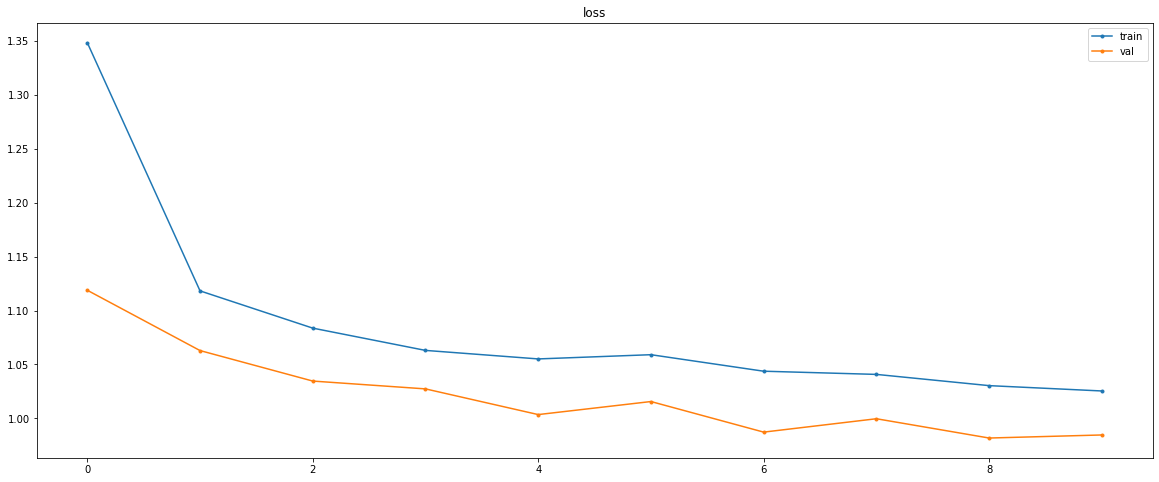

In [205]:
plt.figure(figsize=(20, 8))
plt.title("loss")
plt.plot(np.arange(len(loss_train_all)), loss_train_all, '-o', marker='.', label='train')
plt.plot(np.arange(len(loss_val_all)), loss_val_all, '-o', marker='.', label='val')
plt.legend()
plt.show()

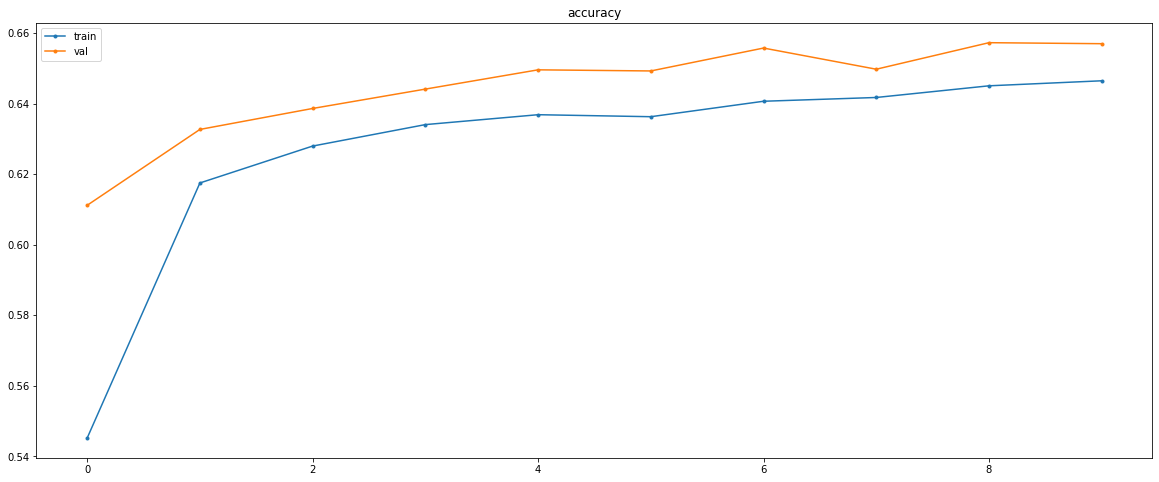

In [198]:
plt.figure(figsize=(20, 8))
plt.title("accuracy")
plt.plot(np.arange(len(accuracy_train_all)), accuracy_train_all, '-o', marker='.', label='train')
plt.plot(np.arange(len(accuracy_val_all)), accuracy_val_all, '-o', marker='.', label='val')
plt.legend()
plt.show()

# ----------------------------------------------------------------------------------------